Loading model...
Model loaded successfully.

--- RUNNING LOOP COMPLETION ABLATION (N=1000) ---


Loop Baseline: 100%|██████████| 1000/1000 [00:02<00:00, 410.54it/s]



--- RUNNING FORAGING ABLATION (N=1000, CL=110) ---


Foraging Baseline: 100%|██████████| 1000/1000 [00:08<00:00, 120.25it/s]


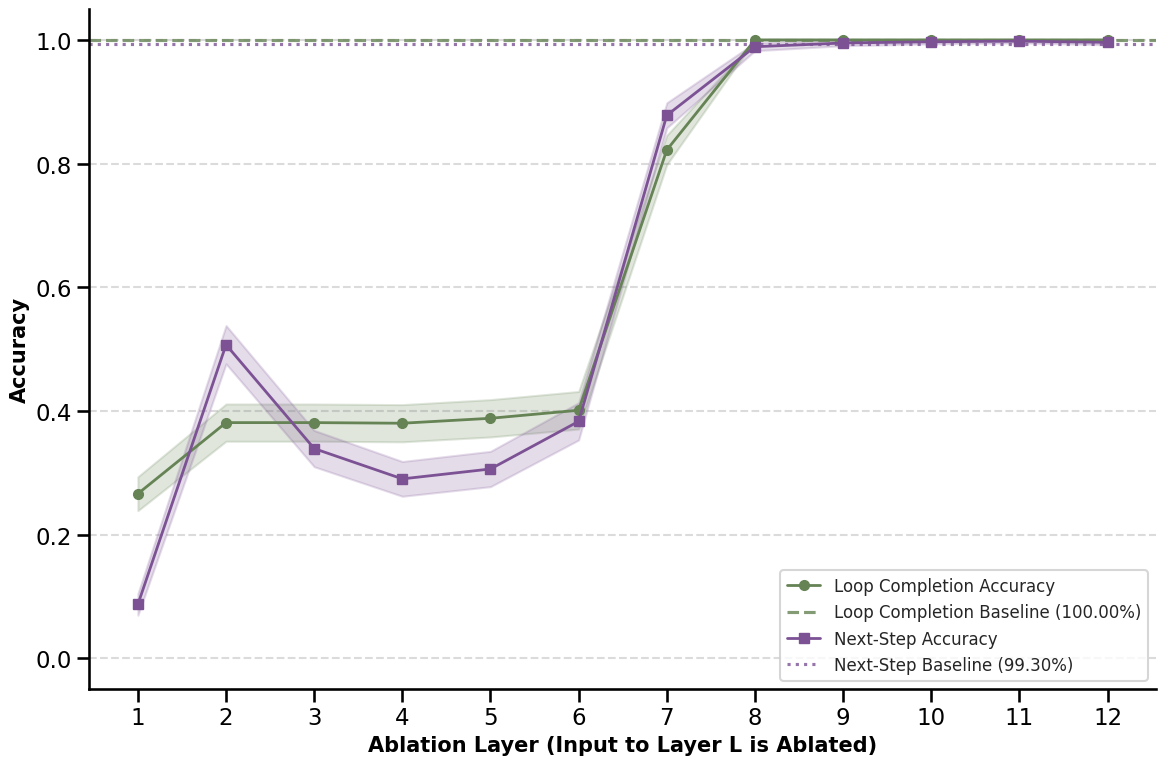


--- COMBINED ABLATION RESULTS SUMMARY ---
Loop Completion Baseline: 100.00%
Next-Step Prediction Baseline: 99.30%

Layer-by-Layer Accuracy:
----------------------------------------
Layer |   Loop Comp. |     Foraging
----------------------------------------
    1 |       26.60% |        8.70%
    2 |       38.10% |       50.70%
    3 |       38.10% |       33.90%
    4 |       38.00% |       29.00%
    5 |       38.80% |       30.60%
    6 |       40.10% |       38.30%
    7 |       82.20% |       87.80%
    8 |      100.00% |       98.90%
    9 |      100.00% |       99.50%
   10 |      100.00% |       99.70%
   11 |      100.00% |       99.80%
   12 |      100.00% |       99.60%
----------------------------------------


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import networkx as nx
from tqdm.auto import tqdm
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class NavigationGPT:
    def __init__(self, model_path: str):
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        if self.tokenizer.pad_token is None: 
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_path, torch_dtype=torch.float32)
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(DEVICE)
        self.model.eval()

class PositionalAblationPatcher:
    def __init__(self, model, layer_idx, target_positions):
        self.model = model
        self.layer_idx = layer_idx
        self.target_positions = target_positions
        self.hook = None
    def _ablation_hook(self, module, module_input):
        original_hidden_states = module_input[0]
        patched_hidden_states = original_hidden_states.clone()
        for pos in self.target_positions:
            if pos < patched_hidden_states.shape[1]:
                patched_hidden_states[0, pos, :] = 0.0
        return (patched_hidden_states,) + module_input[1:]
    def __enter__(self):
        self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook: self.hook.remove()

def create_loop_completion_tasks(num_tasks=100):
    tasks = []
    templates = [
        "{} EAST {} WEST {}", "{} WEST {} EAST {}", "{} NORTH {} SOUTH {}", "{} SOUTH {} NORTH {}",
        "{} EAST {} SOUTH {} WEST {} NORTH {}", "{} SOUTH {} WEST {} NORTH {} EAST {}",
        "{} WEST {} NORTH {} EAST {} SOUTH {}", "{} NORTH {} EAST {} SOUTH {} WEST {}",
        "{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}",
        "{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}",
    ]
    for _ in range(num_tasks):
        template = random.choice(templates)
        num_names = template.count("{}") - 1
        names = [f"{chr(97+random.randint(0,25))}{chr(97+random.randint(0,25))}" for _ in range(num_names)]
        full_path = template.format(*(names + [names[0]]))
        prompt = " ".join(full_path.split()[:-1])
        tasks.append({'prompt': prompt, 'correct_completion': names[0]})
    return tasks

def evaluate_loop_completion(predicted, correct):
    return 1.0 if predicted == correct else 0.0

def get_loop_direction_positions(tokenizer, prompt):
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    positions = []
    vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    for i, token_str in enumerate(decoded):
        if token_str in vocab and i < (len(decoded) - 1):
            positions.append(i)
    return positions

def run_loop_completion_ablation(model, num_trials=100):
    tasks = create_loop_completion_tasks(num_trials)
    num_layers = model.model.config.n_layer
    results = []

    for layer in tqdm(range(num_layers), desc="Loop Completion Ablation"):
        correct = 0
        for task in tasks:
            positions = get_loop_direction_positions(model.tokenizer, task['prompt'])
            with PositionalAblationPatcher(model.model, layer, positions):
                encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
                with torch.no_grad():
                    outputs = model.model(**encodings)
                pred_id = torch.argmax(outputs.logits[0, -1, :]).item()
                pred_node = model.tokenizer.decode(pred_id).strip()
                if evaluate_loop_completion(pred_node, task['correct_completion']) == 1.0:
                    correct += 1
        results.append(correct / len(tasks))
    
    correct_baseline = 0
    for task in tqdm(tasks, desc="Loop Baseline"):
        encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            outputs = model.model(**encodings)
        pred_id = torch.argmax(outputs.logits[0, -1, :]).item()
        pred_node = model.tokenizer.decode(pred_id).strip()
        if evaluate_loop_completion(pred_node, task['correct_completion']) == 1.0:
            correct_baseline += 1
    baseline = correct_baseline / len(tasks)
    return results, baseline

def generate_grid_graph(size=4):
    G = nx.DiGraph()
    nodes = [f"{chr(97+i)}{chr(97+j)}" for i in range(size) for j in range(size)]
    for r in range(size):
        for c in range(size):
            idx = r*size+c
            if c<size-1: G.add_edge(nodes[idx], nodes[idx+1], direction='EAST')
            if c>0: G.add_edge(nodes[idx], nodes[idx-1], direction='WEST')
            if r<size-1: G.add_edge(nodes[idx], nodes[idx+size], direction='SOUTH')
            if r>0: G.add_edge(nodes[idx], nodes[idx-size], direction='NORTH')
    return G, nodes

def create_foraging_tasks(G, nodes, n_tasks, context_length):
    tasks = []
    for _ in range(n_tasks):
        start_node = random.choice(nodes)
        path = [start_node]
        for _ in range(context_length - 1):
            neighbors = list(G.successors(path[-1]))
            if not neighbors: break
            path.append(random.choice(neighbors))
        
        walk_str_parts = [f"{path[i]} {G.edges[path[i], path[i+1]]['direction']}" for i in range(len(path)-1)]
        prompt = " ".join(walk_str_parts) + f" {path[-1]}"
        tasks.append({'prompt': prompt, 'start': path[-1], 'graph': G})
    return tasks

def evaluate_foraging_prediction(pred_dir, pred_node, task):
    graph, start_node = task['graph'], task['start']
    if not graph.has_edge(start_node, pred_node):
        return 0.0
    return 1.0 if graph.edges[start_node, pred_node]['direction'] == pred_dir else 0.0

def get_foraging_direction_positions(tokenizer, prompt):
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    positions = []
    vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    for i, token_str in enumerate(decoded):
        if token_str in vocab:
            positions.append(i)
    return positions

def run_foraging_ablation(model, num_trials=100, context_length=50):
    G, nodes = generate_grid_graph(4)
    tasks = create_foraging_tasks(G, nodes, num_trials, context_length)
    num_layers = model.model.config.n_layer
    results = []

    for layer in tqdm(range(num_layers), desc="Foraging Ablation"):
        correct = 0
        for task in tasks:
            positions = get_foraging_direction_positions(model.tokenizer, task['prompt'])
            with PositionalAblationPatcher(model.model, layer, positions):
                encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
                with torch.no_grad():
                    out1 = model.model(**encodings)
                    pred_dir_id = torch.argmax(out1.logits[0, -1, :]).unsqueeze(0)
                    ids2 = torch.cat([encodings.input_ids[0], pred_dir_id]).unsqueeze(0)
                    out2 = model.model(input_ids=ids2)
                    pred_node_id = torch.argmax(out2.logits[0, -1, :])
                pred_dir = model.tokenizer.decode(pred_dir_id).strip()
                pred_node = model.tokenizer.decode(pred_node_id).strip()
                if evaluate_foraging_prediction(pred_dir, pred_node, task) == 1.0:
                    correct += 1
        results.append(correct / len(tasks))

    correct_baseline = 0
    for task in tqdm(tasks, desc="Foraging Baseline"):
        encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
        with torch.no_grad():
            out1 = model.model(**encodings)
            pred_dir_id = torch.argmax(out1.logits[0, -1, :]).unsqueeze(0)
            ids2 = torch.cat([encodings.input_ids[0], pred_dir_id]).unsqueeze(0)
            out2 = model.model(input_ids=ids2)
            pred_node_id = torch.argmax(out2.logits[0, -1, :])
        pred_dir = model.tokenizer.decode(pred_dir_id).strip()
        pred_node = model.tokenizer.decode(pred_node_id).strip()
        if evaluate_foraging_prediction(pred_dir, pred_node, task) == 1.0:
            correct_baseline += 1
    baseline = correct_baseline / len(tasks)
    return results, baseline

def plot_combined_results(loop_results, loop_baseline, foraging_results, foraging_baseline, num_trials):
    plt.rcParams.update({
        "axes.edgecolor": "black", "axes.linewidth": 2, "xtick.color": "black",
        "ytick.color": "black", "axes.labelcolor": "black", "xtick.major.width": 2,
        "ytick.major.width": 2, "xtick.major.size": 7, "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black", "axes.labelcolor": "black",
        "xtick.color": "black", "ytick.color": "black",
    })

    num_layers = len(loop_results)
    layers = np.arange(1, num_layers + 1)
    
    loop_acc = np.array(loop_results)
    loop_ci = 1.96 * np.sqrt(loop_acc * (1 - loop_acc) / num_trials)
    
    forage_acc = np.array(foraging_results)
    forage_ci = 1.96 * np.sqrt(forage_acc * (1 - forage_acc) / num_trials)
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(layers, loop_acc, marker='o', linestyle='-', color='#658354', 
             label='Loop Completion Accuracy', linewidth=2, markersize=7)
    plt.fill_between(layers, loop_acc - loop_ci, loop_acc + loop_ci, 
                     color='#658354', alpha=0.2)
    plt.axhline(loop_baseline, color='#658354', linestyle='--', alpha=0.8, 
                label=f'Loop Completion Baseline ({loop_baseline:.2%})')
    
    plt.plot(layers, forage_acc, marker='s', linestyle='-', color='#7c5295', 
             label='Next-Step Accuracy', linewidth=2, markersize=7)
    plt.fill_between(layers, forage_acc - forage_ci, forage_acc + forage_ci, 
                     color='#7c5295', alpha=0.2)
    plt.axhline(foraging_baseline, color='#7c5295', linestyle=':', alpha=0.8, 
                label=f'Next-Step Baseline ({foraging_baseline:.2%})')

    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=15, fontweight="heavy")
    plt.ylabel('Accuracy', fontsize=15, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1))
    plt.yticks(np.linspace(0, 1, 6))
    sns.despine()
    plt.ylim(-0.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    NUM_TRIALS = 1000
    CONTEXT_LENGTH = 110

    model = NavigationGPT(MODEL_PATH)
    
    loop_results, loop_baseline = run_loop_completion_ablation(model, num_trials=NUM_TRIALS)
    foraging_results, foraging_baseline = run_foraging_ablation(model, num_trials=NUM_TRIALS, context_length=CONTEXT_LENGTH)
    plot_combined_results(loop_results, loop_baseline, foraging_results, foraging_baseline, num_trials=NUM_TRIALS)
    
    print("\n" + "="*80)
    print("--- COMBINED ABLATION RESULTS SUMMARY ---")
    print("="*80)
    print(f"Loop Completion Baseline: {loop_baseline:.2%}")
    print(f"Next-Step Prediction Baseline: {foraging_baseline:.2%}")
    print("\nLayer-by-Layer Accuracy:")
    print("-" * 40)
    print(f"{'Layer':>5} | {'Loop Comp.':>12} | {'Foraging':>12}")
    print("-" * 40)
    for i in range(len(loop_results)):
        print(f"{i+1:5d} | {loop_results[i]:12.2%} | {foraging_results[i]:12.2%}")
    print("-" * 40)

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model...
Model loaded successfully.

--- RUNNING ABLATION FOR 2-HOP LOOPS (N=1000) ---


Baseline 2-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 417.40it/s]



--- RUNNING ABLATION FOR 4-HOP LOOPS (N=1000) ---


Baseline 4-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 419.50it/s]



--- RUNNING ABLATION FOR 6-HOP LOOPS (N=1000) ---


Baseline 6-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 415.75it/s]



--- RUNNING ABLATION FOR 8-HOP LOOPS (N=1000) ---


Baseline 8-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 413.57it/s]



--- RUNNING ABLATION FOR 10-HOP LOOPS (N=1000) ---


Baseline 10-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 414.89it/s]



--- RUNNING ABLATION FOR 12-HOP LOOPS (N=1000) ---


Baseline 12-Hop Loops: 100%|██████████| 1000/1000 [00:02<00:00, 414.40it/s]


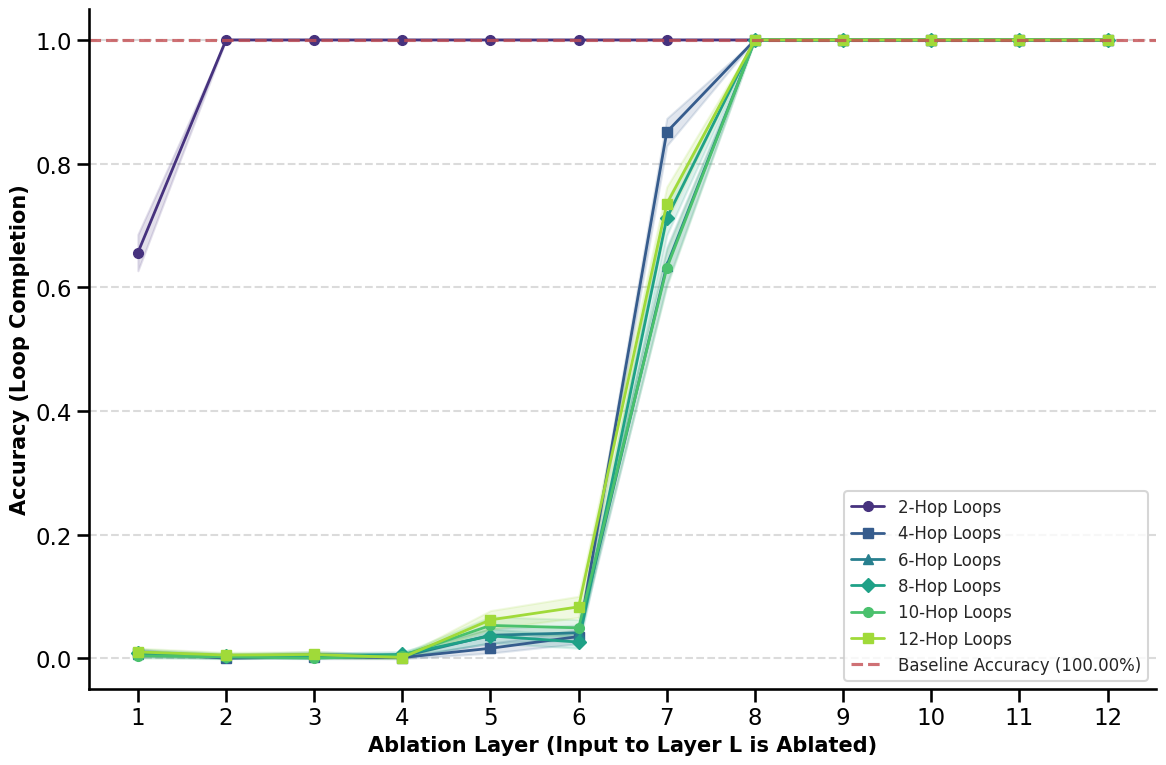


--- STRATIFIED ABLATION RESULTS SUMMARY ---
Layer | 2-Hops     | 4-Hops     | 6-Hops     | 8-Hops     | 10-Hops     | 12-Hops     |
---------------------------------------------------------------------------------------
    1 |     65.60% |      0.90% |      0.70% |      0.90% |      0.40% |      1.00% |
    2 |    100.00% |      0.00% |      0.30% |      0.40% |      0.20% |      0.50% |
    3 |    100.00% |      0.20% |      0.60% |      0.40% |      0.00% |      0.60% |
    4 |    100.00% |      0.10% |      0.30% |      0.60% |      0.40% |      0.10% |
    5 |    100.00% |      1.60% |      3.70% |      3.60% |      5.30% |      6.20% |
    6 |    100.00% |      3.50% |      4.10% |      2.60% |      4.90% |      8.30% |
    7 |    100.00% |     85.10% |     63.50% |     71.20% |     63.10% |     73.50% |
    8 |    100.00% |    100.00% |    100.00% |    100.00% |    100.00% |    100.00% |
    9 |    100.00% |    100.00% |    100.00% |    100.00% |    100.00% |    100.00% |
   10

In [1]:
# direction ablation vs performance on loop completion, stratified by hop counts

def create_loop_completion_tasks(num_tasks, num_hops):
    templates_by_hops = {
        2: ["{} EAST {} WEST {}", "{} WEST {} EAST {}", "{} NORTH {} SOUTH {}", "{} SOUTH {} NORTH {}"],
        4: ["{} EAST {} SOUTH {} WEST {} NORTH {}", "{} NORTH {} EAST {} SOUTH {} WEST {}", "{} SOUTH {} WEST {} NORTH {} EAST {}", "{} WEST {} NORTH {} EAST {} SOUTH {}"],
        6: ["{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}", "{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}", "{} WEST {} WEST {} SOUTH {} EAST {} EAST {} NORTH {}", "{} SOUTH {} SOUTH {} EAST {} NORTH {} NORTH {} WEST {}"],
        8: ["{} EAST {} EAST {} EAST {} SOUTH {} WEST {} WEST {} WEST {} NORTH {}", "{} SOUTH {} SOUTH {} SOUTH {} EAST {} NORTH {} NORTH {} NORTH {} WEST {}", "{} WEST {} WEST {} WEST {} SOUTH {} EAST {} EAST {} EAST {} NORTH {}", "{} NORTH {} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {}"],
        10: ["{} EAST {} EAST {} EAST {} SOUTH {} SOUTH {} WEST {} WEST {} WEST {} NORTH {} NORTH {}", "{} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} NORTH {} NORTH {} NORTH {} WEST {} WEST {}", "{} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} EAST {} EAST {} EAST{} NORTH {} NORTH {}", "{} NORTH {} NORTH {} NORTH {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {}"],
        12: ["{} EAST {} EAST {} EAST {} SOUTH {} SOUTH {} SOUTH {} WEST {} WEST {} WEST {} NORTH {} NORTH {} NORTH {}", "{} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {} NORTH {} NORTH {} NORTH {} WEST {} WEST {} WEST {}", "{} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST{} NORTH {} NORTH {} NORTH {}", "{} NORTH {} NORTH {} NORTH {} WEST {} WEST {} WEST {} SOUTH {} SOUTH {} SOUTH {} EAST {} EAST {} EAST {}"]
    }
    
    if num_hops not in templates_by_hops:
        raise ValueError(f"No templates available for {num_hops} hops. Available: {list(templates_by_hops.keys())}")

    tasks = []
    available_templates = templates_by_hops[num_hops]
    
    for _ in range(num_tasks):
        template = random.choice(available_templates)
        num_unique_names = num_hops
        names = [f"{chr(97+random.randint(0,25))}{chr(97+random.randint(0,25))}" for _ in range(num_unique_names)]
        full_path_names = names + [names[0]]
        filled_template = template.format(*full_path_names)
        
        prompt_parts = filled_template.split()
        prompt = " ".join(prompt_parts[:-1])
        correct_completion = names[0]
        
        tasks.append({'prompt': prompt, 'correct_completion': correct_completion})
    return tasks

def evaluate_loop_completion(predicted, correct):
    return 1.0 if predicted == correct else 0.0

def get_direction_positions_to_ablate(tokenizer, prompt):
    tokens = tokenizer(prompt, return_tensors="pt")
    decoded_tokens = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
    direction_positions = []
    direction_vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
    for i, token_str in enumerate(decoded_tokens):
        if token_str in direction_vocab and i < (len(decoded_tokens) - 1):
            direction_positions.append(i)
    return direction_positions

def run_stratified_loop_ablation(model, hop_counts_to_test, num_trials=100):
    results_by_hop = {}
    baselines_by_hop = {}
    num_layers = model.model.config.n_layer

    for hops in hop_counts_to_test:
        tasks = create_loop_completion_tasks(num_tasks=num_trials, num_hops=hops)
        layer_accuracies = []

        for layer_to_ablate in tqdm(range(num_layers), desc=f"Ablating {hops}-Hop Loops"):
            correct_predictions = 0
            for task in tasks:
                positions_to_ablate = get_direction_positions_to_ablate(model.tokenizer, task['prompt'])
                with PositionalAblationPatcher(model.model, layer_to_ablate, positions_to_ablate):
                    encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
                    with torch.no_grad():
                        outputs = model.model(**encodings)
                    predicted_id = torch.argmax(outputs.logits[0, -1, :]).item()
                    predicted_node = model.tokenizer.decode(predicted_id).strip()
                    if evaluate_loop_completion(predicted_node, task['correct_completion']) == 1.0:
                        correct_predictions += 1
            layer_accuracies.append(correct_predictions / len(tasks))
        
        results_by_hop[hops] = layer_accuracies

        correct_baseline = 0
        for task in tqdm(tasks, desc=f"Baseline {hops}-Hop Loops"):
            encodings = model.tokenizer(task['prompt'], return_tensors='pt').to(DEVICE)
            with torch.no_grad():
                outputs = model.model(**encodings)
            predicted_id = torch.argmax(outputs.logits[0, -1, :]).item()
            predicted_node = model.tokenizer.decode(predicted_id).strip()
            if evaluate_loop_completion(predicted_node, task['correct_completion']) == 1.0:
                correct_baseline += 1
        baselines_by_hop[hops] = correct_baseline / len(tasks)

    return results_by_hop, baselines_by_hop

def plot_stratified_results(results_by_hop, baselines_by_hop, num_trials):
    plt.rcParams.update({
        "axes.edgecolor": "black", "axes.linewidth": 2, "xtick.color": "black",
        "ytick.color": "black", "axes.labelcolor": "black", "xtick.major.width": 2,
        "ytick.major.width": 2, "xtick.major.size": 7, "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black", "axes.labelcolor": "black",
        "xtick.color": "black", "ytick.color": "black",
    })

    num_layers = len(next(iter(results_by_hop.values())))
    layers = np.arange(1, num_layers + 1)
    
    colors = sns.color_palette("viridis", n_colors=len(results_by_hop))
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    plt.figure(figsize=(12, 8))
    
    for i, (hops, results) in enumerate(results_by_hop.items()):
        acc = np.array(results)
        ci = 1.96 * np.sqrt(acc * (1 - acc) / num_trials)
        
        plt.plot(layers, acc, marker=markers[i % len(markers)], linestyle='-', color=colors[i], 
                 label=f'{hops}-Hop Loops', linewidth=2, markersize=7)
        plt.fill_between(layers, acc - ci, acc + ci, color=colors[i], alpha=0.15)
        
    baseline_value = 1.0
    plt.axhline(baseline_value, color='r', linestyle='--', alpha=0.8, 
                label=f'Baseline Accuracy ({baseline_value:.2%})')

    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=15, fontweight="heavy")
    plt.ylabel('Accuracy (Loop Completion)', fontsize=15, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1))
    plt.yticks(np.linspace(0, 1, 6))
    sns.despine()
    plt.ylim(-0.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12) 
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    NUM_TRIALS_PER_HOP = 1000
    HOP_COUNTS_TO_TEST = [2, 4, 6, 8, 10, 12]

    model = NavigationGPT(MODEL_PATH)
    
    results_by_hop, baselines_by_hop = run_stratified_loop_ablation(
        model, 
        hop_counts_to_test=HOP_COUNTS_TO_TEST, 
        num_trials=NUM_TRIALS_PER_HOP
    )

    plot_stratified_results(results_by_hop, baselines_by_hop, num_trials=NUM_TRIALS_PER_HOP)

    print("\n" + "="*80)
    print("--- STRATIFIED ABLATION RESULTS SUMMARY ---")
    print("="*80)
    header = f"{'Layer':>5} |" + "".join([f" {h}-Hops {'':>4}|" for h in HOP_COUNTS_TO_TEST])
    print(header)
    print("-" * len(header))
    for i in range(len(next(iter(results_by_hop.values())))):
        row = f"{i+1:5d} |"
        for h in HOP_COUNTS_TO_TEST:
            row += f" {results_by_hop[h][i]:10.2%} |"
        print(row)
    print("-" * len(header))
    baseline_row = f"{'Base':>5} |"
    for h in HOP_COUNTS_TO_TEST:
        baseline_row += f" {baselines_by_hop[h]:10.2%} |"
    print(baseline_row)
    print("="*80)

Loading model and tokenizer...
Model loaded successfully.
--- STARTING LAYER-SWEPT MEMORY ABLATION (N=1000 trials) ---


Sweeping Ablation Layer: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it]


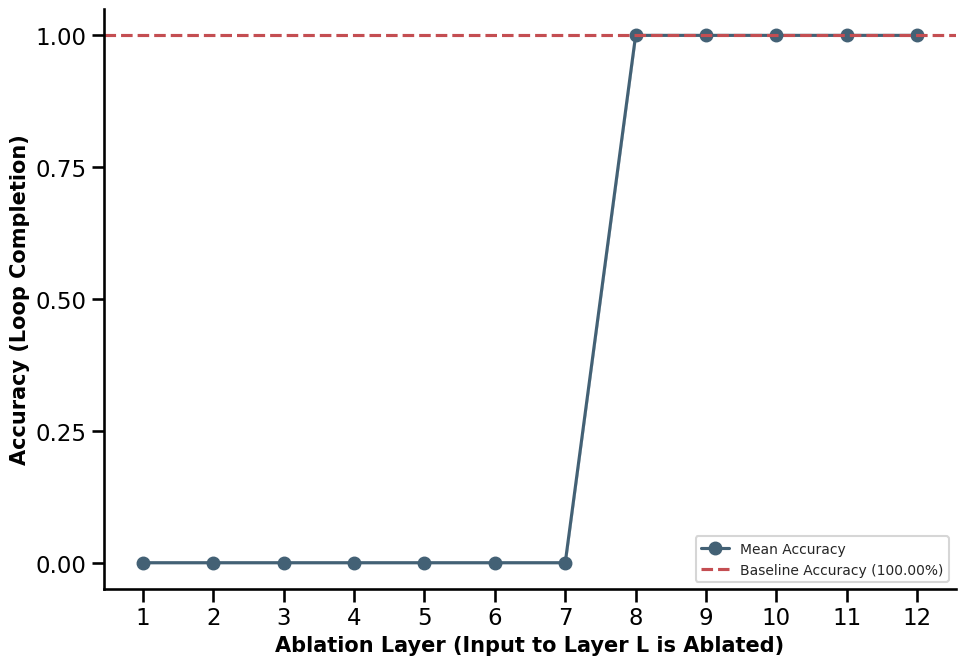

In [ ]:
# Layer-Swept Memory Ablation Plot with CI Shading
# Tests when direction information becomes redundant in the model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.auto import tqdm
import seaborn as sns

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/fv1_model_chunked/scheckpoint-73000"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

class PositionalAblationPatcher:
    """Context manager to ablate (zero-out) hidden states at specific token positions."""
    def __init__(self, model, layer_idx, target_positions):
        self.model = model
        self.layer_idx = layer_idx
        self.target_positions = target_positions
        self.hook = None

    def _ablation_hook(self, module, module_input):
        original_hidden_states = module_input[0]
        patched_hidden_states = original_hidden_states.clone()
        for pos in self.target_positions:
            if pos < patched_hidden_states.shape[1]:
                patched_hidden_states[0, pos, :] = 0.0
        return (patched_hidden_states,) + module_input[1:]

    def __enter__(self):
        self.hook = self.model.transformer.h[self.layer_idx].register_forward_pre_hook(self._ablation_hook)

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.hook:
            self.hook.remove()

def run_layer_swept_memory_ablation(model, tokenizer, num_trials=100):
    """
    Ablates historical directions at each layer and measures the impact on accuracy.
    """
    print(f"--- STARTING LAYER-SWEPT MEMORY ABLATION (N={num_trials} trials) ---")
    
    tasks = []
    for _ in range(num_trials):
        templates = [
            "aa NORTH bb WEST cc SOUTH dd EAST",
            "ab EAST bb SOUTH cb WEST ca NORTH"
        ]
        prompt = random.choice(templates)
        expected_prediction = prompt.split()[0]
        tasks.append({'prompt': prompt, 'expected': expected_prediction})

    num_layers = model.config.n_layer
    results_by_layer = []

    # ablation sweep
    for layer_to_ablate in tqdm(range(num_layers), desc="Sweeping Ablation Layer"):
        correct_predictions = 0
        display_idx = layer_to_ablate + 1  # shift index for reporting (1–12)

        for task in tasks:
            prompt = task['prompt']
            expected_token = task['expected']
            
            tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            decoded_tokens = [tokenizer.decode(t).strip() for t in tokens['input_ids'][0]]
            direction_vocab = {"NORTH", "SOUTH", "EAST", "WEST"}
            
            direction_positions_to_ablate = [i for i, token_str in enumerate(decoded_tokens)
                                             if token_str in direction_vocab and i < (len(decoded_tokens) - 1)]
            
            with PositionalAblationPatcher(model, layer_to_ablate, direction_positions_to_ablate):
                with torch.no_grad():
                    ablated_outputs = model(**tokens)
            
            ablated_pred_id = torch.argmax(ablated_outputs.logits[0, -1, :]).item()
            ablated_pred_token = tokenizer.decode(ablated_pred_id).strip()
            
            if ablated_pred_token == expected_token:
                correct_predictions += 1
                
        accuracy = correct_predictions / num_trials
        results_by_layer.append(accuracy)

    # baseline acc
    correct_baseline = 0
    for task in tasks:
        tokens = tokenizer(task['prompt'], return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            baseline_outputs = model(**tokens)
        baseline_pred_id = torch.argmax(baseline_outputs.logits[0, -1, :]).item()
        baseline_pred_token = tokenizer.decode(baseline_pred_id).strip()
        if baseline_pred_token == task['expected']:
            correct_baseline += 1
    baseline_accuracy = correct_baseline / num_trials

    plt.rcParams.update({
        "axes.edgecolor": "black",
        "axes.linewidth": 2,
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "xtick.major.width": 2,
        "ytick.major.width": 2,
        "xtick.major.size": 7,
        "ytick.major.size": 7,
    })
    sns.set_theme(style="ticks", context="talk", rc={
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    layers = np.arange(1, num_layers + 1)
    mean_acc = np.array(results_by_layer)
    ci_margin = 1.96 * np.sqrt(mean_acc * (1 - mean_acc) / num_trials)  # 95% CI for proportion

    # plotting
    plt.figure(figsize=(10, 7))
    plt.plot(layers, mean_acc, marker='o', linestyle='-', color='#436175', label='Mean Accuracy')
    plt.fill_between(layers, mean_acc - ci_margin, mean_acc + ci_margin, color='#436175', alpha=0.2, label='_nolegend_')

    plt.axhline(baseline_accuracy, color='r', linestyle='--', label=f'Baseline Accuracy ({baseline_accuracy:.2%})')
    plt.xlabel('Ablation Layer (Input to Layer L is Ablated)', fontsize=15, fontweight="heavy")
    plt.ylabel('Accuracy (Loop Completion)', fontsize=15, fontweight="heavy")
    plt.xticks(range(1, num_layers + 1))
    plt.yticks(np.linspace(0, 1, 5))
    sns.despine()
    plt.ylim(-0.05, 1.05)
    plt.grid(False)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    from transformers import GPT2LMHeadModel, GPT2TokenizerFast

    print("Loading model and tokenizer...")
    tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_PATH)
    model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")

    run_layer_swept_memory_ablation(model, tokenizer, num_trials=1000)
